In [1]:
import re

import pandas as pd
import emoji
pd.set_option("display.max_columns", None)
pd.set_option("display.max_row", 100)

import seaborn as sns
# Réglage seaborn
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_context(rc={'patch.linewidth': 0.2})
sns.set_palette("hls", 8)

In [2]:
tweets = pd.read_csv('Tweets.csv')

In [3]:
tweets

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [4]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

## Analyse des sentiments

In [5]:
tweets['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

<AxesSubplot:xlabel='airline_sentiment', ylabel='Count'>

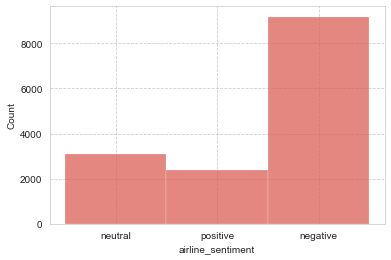

In [6]:
sns.histplot(x='airline_sentiment', data=tweets)

Données très imbalanced avec une sur-représentation des avis négatifs.

- Suppression d'avis négatifs pour rétablir la balance du jeu de données

In [7]:
tweets.query('airline_sentiment == "negative"')['negativereason'].unique()

array(['Bad Flight', "Can't Tell", 'Late Flight',
       'Customer Service Issue', 'Flight Booking Problems',
       'Lost Luggage', 'Flight Attendant Complaints', 'Cancelled Flight',
       'Damaged Luggage', 'longlines'], dtype=object)

In [8]:
tweets.query('airline_sentiment == "negative"')['negativereason'].isna().value_counts()

False    9178
Name: negativereason, dtype: int64

Tous les avis négatifs sont taggés d'une raison, mais présence de Can't Tell qui signifie que la raison n'est pas connue

In [9]:
neg_value = tweets['negativereason'].value_counts()
percent =  round(tweets['negativereason'].value_counts() / len(tweets.query('airline_sentiment == "negative"')),2).mul(100).astype('str') + "%"
pd.DataFrame({'Neg value counts' : neg_value, 'Percentage' : percent})

,Neg value counts,Percentage
Customer Service Issue,2910,32.0%
Late Flight,1665,18.0%
Can't Tell,1190,13.0%
Cancelled Flight,847,9.0%
Lost Luggage,724,8.0%
Bad Flight,580,6.0%
Flight Booking Problems,529,6.0%
Flight Attendant Complaints,481,5.0%
longlines,178,2.0%
Damaged Luggage,74,1.0%


- 13% des raisons pour un avis négatifs ne sont pas connus
- 32% sont des avis en lien avec le service client
- Peu d'avis négatifs à cause de bagages perdus/endommagés

# Preprocessing des tweets

In [10]:
tweets.loc[:,'text']

0                      @VirginAmerica What @dhepburn said.
1        @VirginAmerica plus you've added commercials t...
2        @VirginAmerica I didn't today... Must mean I n...
3        @VirginAmerica it's really aggressive to blast...
4        @VirginAmerica and it's a really big bad thing...
                               ...                        
14635    @AmericanAir thank you we got on a different f...
14636    @AmericanAir leaving over 20 minutes Late Flig...
14637    @AmericanAir Please bring American Airlines to...
14638    @AmericanAir you have my money, you change my ...
14639    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object

In [11]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr=WordNetLemmatizer()
stop_words=stopwords.words("english")

In [12]:
def clean_text(text):
    
    #Put text into lower case
    text=text.lower()
    
    #Remove URLs
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    
    #Remove Hashtags
    text = re.sub(r"#", "", text)
                  
    #Remove Mentions
    text = re.sub(r"@\S+", "", text)
    
    #Handling Emojis/Emoticons
    text=emoji.demojize(text)
    
    emoticons = dict()
    emoticons['EMOT_SMILEY']=[':-)', ':)', '(:', '(-:', ';p', ':-d', ':d',]
    emoticons['EMOT_LAUGH']=[':-D', ':D', 'X-D', 'XD', 'xD']
    emoticons['EMOT_LOVE']=['<3', ':\*',]
    emoticons['EMOT_CRY']=[':,(', ':\'(', ':"(', ':((']
    emoticons['EMOT_WINK']=[';-)', ';)', ';-D', ';D', '(;', '(-;']
    emoticons['EMOT_FROWN']=[':-(', ':(']
    for label,emot in emoticons.items():
        for word in text.split():
            if word in emot:
                text=text.replace(word,label)
    #Lemmatazation
    text=' '.join([lmtzr.lemmatize(word,'v') for word in text.split()])
    return text
    

In [13]:
tweets = tweets.assign(text_clean = tweets['text'].apply(lambda x : clean_text(x)))

In [14]:
tweets.loc[:,['text','text_clean']]

,text,text_clean
0,@VirginAmerica What @dhepburn said.,what said.
1,@VirginAmerica plus you've added commercials t...,plus you've add commercials to the experience....
2,@VirginAmerica I didn't today... Must mean I n...,i didn't today... must mean i need to take ano...
3,@VirginAmerica it's really aggressive to blast...,"it's really aggressive to blast obnoxious ""ent..."
4,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it
...,...,...
14635,@AmericanAir thank you we got on a different f...,thank you we get on a different flight to chic...
14636,@AmericanAir leaving over 20 minutes Late Flig...,leave over 20 minutes late flight. no warn or ...
14637,@AmericanAir Please bring American Airlines to...,please bring american airlines to blackberry10
14638,"@AmericanAir you have my money, you change my ...","you have my money, you change my flight, and d..."


In [15]:
# This line gets the number of word in each cleaned tweets (in order to get the max)
tweets = tweets.assign(num_words = tweets['text_clean'].apply(lambda x : len(x.split(' '))))

In [16]:
max_words = tweets['num_words'].max()

In [59]:
tweets['airline_sentiment'] = tweets['airline_sentiment'].astype('category')
encoded_dict = {'negative' : 0, 'neutral' : 1, 'positive' : 2}

tweets['airline_sentiment'] = tweets['airline_sentiment'].cat.codes

In [62]:
from imblearn.under_sampling import RandomUnderSampler
X = tweets['text_clean'].values.reshape(-1,1)
y = tweets['airline_sentiment'].values

undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(X, y)

print(f'Taille du dataset initial : {X.shape[0]}, Taille du dataset undersamplé : {X_under.shape[0]}')

Taille du dataset initial : 14640, Taille du dataset undersamplé : 7089


<AxesSubplot:ylabel='Count'>

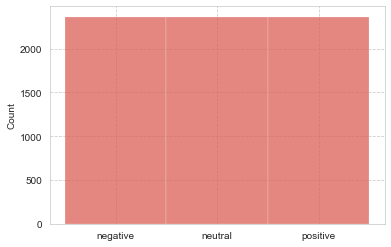

In [19]:
sns.histplot(y_under)

Le jeu de données a bien été rebalancé avec une proportion égale parmi les 3 classes

# Train test split

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, random_state = 42, test_size = 0.33)

print(f'Length of X_train : {len(X_train)}, Length of X_test : {X_test.shape[0]}')

Length of X_train : 4749, Length of X_test : 2340


# Transformers ! 

In [21]:
from transformers import AutoTokenizer, TFBertModel
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased', num_labels=3)
bert = TFBertModel.from_pretrained('distilbert-base-uncased', num_labels=3)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFBertModel: ['vocab_transform', 'distilbert', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stre

In [22]:
tokenizer('Hello my name is pierre')

{'input_ids': [101, 7592, 2026, 2171, 2003, 5578, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

We tokenize our train and test set

In [68]:
X_train = tokenizer(
        text=X_train.reshape(-1).tolist(),
        add_special_tokens=True,
        max_length=max_words,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True)


X_test = tokenizer(
        text=X_test.reshape(-1).tolist(),
        add_special_tokens=True,
        max_length=max_words,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True)

In [36]:
X_train['input_ids']

<tf.Tensor: shape=(4749, 35), dtype=int32, numpy=
array([[  101,  2178, 18794, ...,     0,     0,     0],
       [  101,  2053,  1012, ...,     0,     0,     0],
       [  101,  2107,  1037, ...,     0,     0,     0],
       ...,
       [  101,  7929,  4283, ...,     0,     0,     0],
       [  101,  1018,  3566, ...,     0,     0,     0],
       [  101,  6854,  2320, ...,     0,     0,     0]])>

In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf

In [40]:

max_len = max_words

input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
input_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

bert_inputs = {'input_ids': input_ids, 'input_mask': input_mask}

embeddings = bert(input_ids, attention_mask=input_mask)[0] #Here 0 is the last hidden states
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)

# Last layer
y = Dense(3, activation = 'sigmoid')(out) #Here 3 because we got 3 categories to predict and sigmoid because we want probabilities

model = tf.keras.Model(inputs=bert_inputs, outputs=y)
model.layers[2].trainable=True


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

# Tutoriel de la documentation HuggingFace

In [41]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

batch_size = 8
num_epochs = 3
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_steps = len(X_train) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=lr_scheduler)

In [72]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [73]:
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [47]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 35)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 35)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           tf_bert_model[0][0]   

In [50]:
tf.keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
model.fit(
    x={'input_ids' : X_train['input_ids'],'attention_mask' : X_train['attention_mask']},
    y=to_categorical(y_train),
    validation_data=(
        {'input_ids' : X_test['input_ids'],'attention_mask' : X_test['attention_mask']}, 
        to_categorical(y_test)
    ), epochs=3)

Epoch 1/3
  3/149 [..............................] - ETA: 16:04 - loss: 1.1660 - accuracy: 0.3438

4749